# HD155358 - Find optimal viewing angle for Robertson et al. (2012) fit.

In [5]:
import pandas as pd
import numpy as np
import rebound
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
data = pd.read_csv("RV.txt", delimiter=' ')

In [68]:
#Don't want to move to COM, want to see relative to the background. 
def fit_RVRobertson(times,theta):
    m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini,phi = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoyr2pi = 2*np.pi/365.              #days -> yr/2pi
    mJ = 9.543e-4                        #Jupiter mass -> solar mass
    
    v = np.empty(0)    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=0.92)                      #add the star
    sim.testparticle_type = 1            #ignore planet-planet interactions
    sim.N_active = sim.N                 #ignore planet-planet interactions
    sim.dt = 2*np.pi* a1**(1.5) / 25. 
    sim.add(m=m1sini*mJ/sini,a=a1,M=M1,e=e1,omega=w1) 
    sim.add(m=m2sini*mJ/sini,a=a2,M=M2,e=e2,omega=w2)  
    sim.move_to_com()
    #orbit1 = sim.particles[1].calculate_orbit(sim.particles[0])
    #orbit2 = sim.particles[2].calculate_orbit(sim.particles[0])
    for t in times*dtoyr2pi:
        sim.integrate(t)
        #v = np.append(v,-AUyr2ms*sim.particles[0].vy*sini)
        v = np.append(v,AUyr2ms*(sim.particles[0].vx*np.sin(phi) + sim.particles[0].vy*np.cos(phi))*sini) #coordinate transf from (x,y,z)->(x',y',z'), take y' component
    return v 

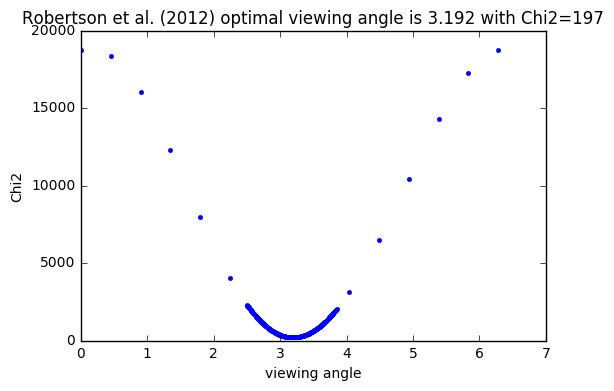

In [69]:
#find optimal Robertson et al. (2012) angle
d2R = np.pi/180
t0 = data["BJD"].iloc[0]
times = data["BJD"] - t0                   #in Barycentric Julian Date (days)
m1sini,m2sini = 0.85,0.82                  #Jupiter masses, default 0.85,0.82
a1,a2 = 0.64, 1.02                          #AU, default: 0.64, 1.02
e1,e2 = 0.17,0.16                          #default: 0.17,0.16
w1,w2 = 150*d2R, 180*d2R                           #in radians, default: 143, 180
M1,M2 = 129*d2R, 233*d2R                           #in degrees, default: 129, 233
sini = 1
Chi2 = []

offset = 3.75

Nruns = 200
phi = np.concatenate((np.linspace(0,2*np.pi,15),np.linspace(2.5,3.85,Nruns)))
for p in phi:
    theta = m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini,p
    RV = fit_RVRobertson(times,theta)
    Chi2.append(sum( ((RV + offset - data["RV"])/data["Unc"])**2 ))

plt.plot(phi,Chi2,'.')
plt.ylabel('Chi2')
plt.xlabel('viewing angle')
plt.title('Robertson et al. (2012) optimal viewing angle is %.3f with Chi2=%d'%(phi[Chi2.index(min(Chi2))],min(Chi2)))
plt.savefig("Robertson_viewingangle_whfast.png")

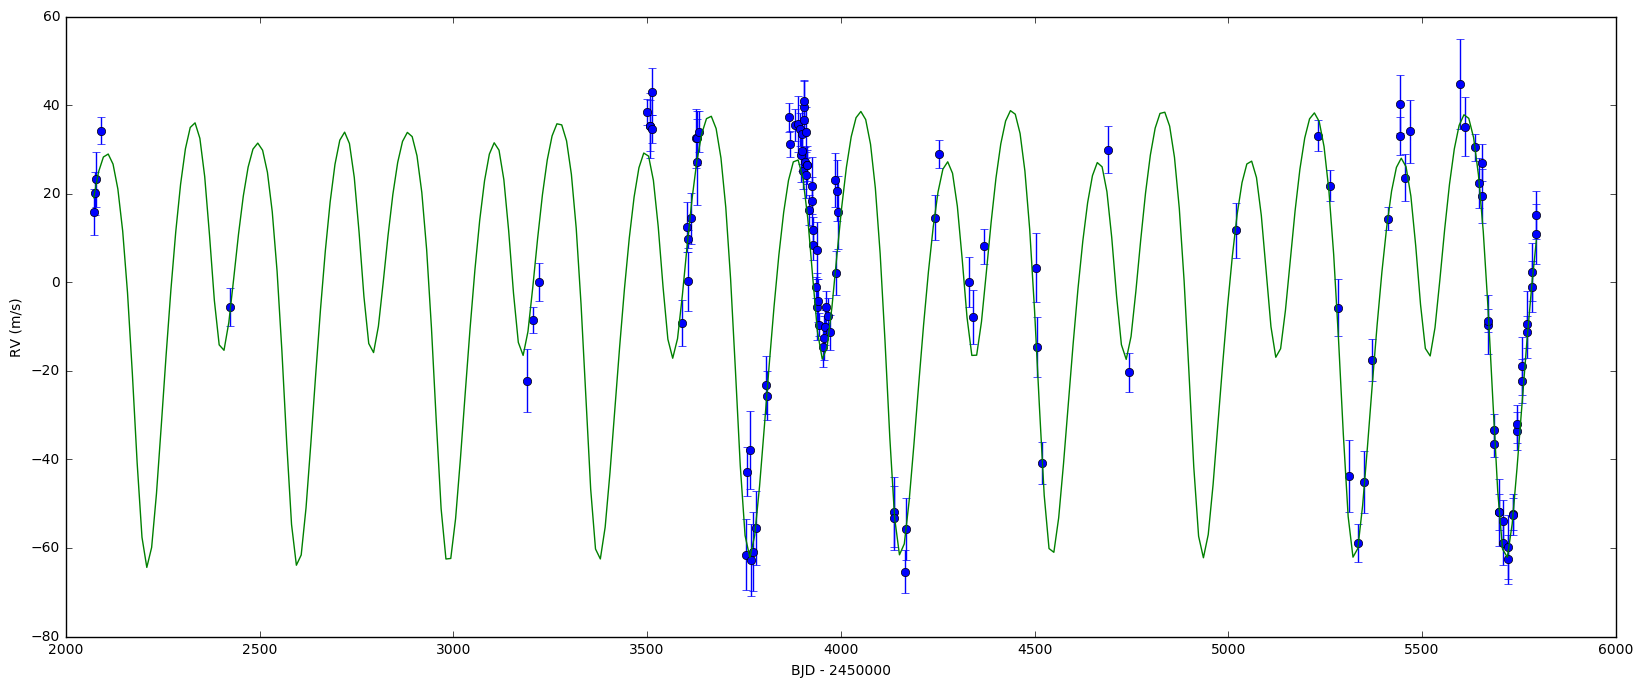

In [15]:
tt = np.linspace(t0,max(data["BJD"]),300)
times = tt - t0

theta = m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini,phi[Chi2.index(min(Chi2))]
RV = fit_RVRobertson(times,theta)
plt.figure(figsize=(20,8))
plt.errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o')
plt.plot(tt,RV)
plt.xlabel("BJD - 2450000")
plt.ylabel("RV (m/s)")